In [181]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [182]:
### Loading Data
data = pd.read_csv('C:/Users/78425/Desktop/Diplomatura/Modulo1/Primer_Ejercicio/data.csv')
tag = pd.read_csv('C:/Users/78425/Desktop/Diplomatura/Modulo1/Primer_Ejercicio/tag.csv')

In [183]:
pd.set_option('display.max_columns',30)

In [184]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [185]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [186]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [187]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

In [188]:
tag.head()

,SUSCRIBER_KEY,Total
0,E_63734494_20190215,0
1,E_66977552_20190518,0
2,E_69159695_20180116,4
3,E_65255730_20190416,3
4,E_67893872_20161201,0


Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [189]:
tag['Total']= tag['Total']==0

In [190]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [191]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,True
1,E_66977552_20190518,True
2,E_69159695_20180116,False
3,E_65255730_20190416,False
4,E_67893872_20161201,True


In [192]:
tag['Target'] = tag['Target'].astype(int)

In [193]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,1
1,E_66977552_20190518,1
2,E_69159695_20180116,0
3,E_65255730_20190416,0
4,E_67893872_20161201,1


In [194]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

 Unimos los datasets

In [195]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


In [196]:
del tag
del data

In [197]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 213 entries, SUSCRIBER_KEY to Target
dtypes: float64(103), int32(1), int64(97), object(12)
memory usage: 520.0+ MB


 ## Empecemos a limpiar columnas 

Todas las que dicen en el documento 'No se usa', Chau

In [198]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

In [199]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [200]:
que_quedaron= ["USE_LCL_VOI_AMT_M1",
"USE_LCL_VOI_AMT_M2",
"USE_LCL_VOI_AMT_M3",]

In [201]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [202]:
fulldata.shape

(319222, 192)

In [203]:
print(fulldata.columns)

Index(['SUSCRIBER_KEY', 'FECHA_CORTE', 'LAT_PROV_BTS', 'LON_PROV_BTS',
       'LAT_CITY_BTS', 'LON_CITY_BTS', 'VALUE_SEGMENT', 'SEGMENTATION',
       'MICROSEGMENTATION', 'SOURCE',
       ...
       'PACK_DATA_EXP_W4', 'PACK_DATA_EXP_W5', 'PACK_DATA_EXP_W6',
       'PACK_DATA_EXP_W7', 'PACK_DATA_EXP_W8', 'PACK_DATA_EXP_W9',
       'PACK_DATA_EXP_W10', 'PACK_DATA_EXP_W11', 'PACK_DATA_EXP_W12',
       'Target'],
      dtype='object', length=192)


# ME HABÍAN QUEDADO LAS QUE TIENEN UN SOLO VALOR (OJO!!!) 

In [204]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [205]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [206]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

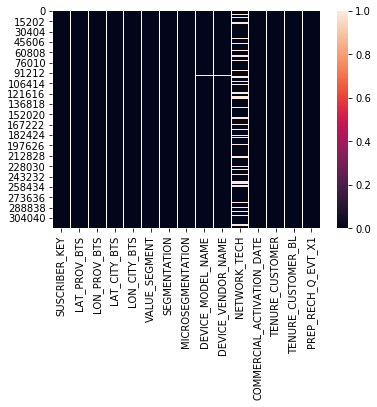

In [207]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [208]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [209]:
missing = pd.Series(nullcount)

In [210]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

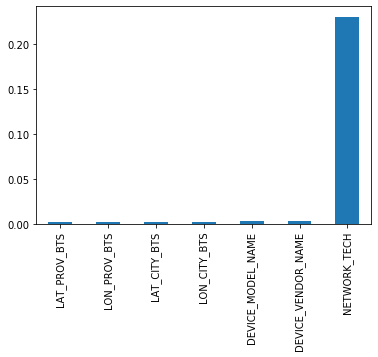

In [211]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

In [212]:
fulldata.shape[0]

319222

# Limpieza de datos categoricos

Analizamos los datos categoricos

In [213]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int32(1), int64(97), object(10)
memory usage: 464.0+ MB


In [214]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [215]:
cat_columns

['PREP_RECH_LAST_DAY_12W',
 'SUSCRIBER_KEY',
 'PREP_RECH_CHNNL_MODE12W',
 'MICROSEGMENTATION',
 'VALUE_SEGMENT',
 'SEGMENTATION',
 'COMMERCIAL_ACTIVATION_DATE',
 'DEVICE_VENDOR_NAME',
 'NETWORK_TECH',
 'DEVICE_MODEL_NAME']

In [216]:
Cat_fulldata =  fulldata[['SEGMENTATION',
 'PREP_RECH_CHNNL_MODE12W',
 'DEVICE_MODEL_NAME',
 'COMMERCIAL_ACTIVATION_DATE',
 'PREP_RECH_LAST_DAY_12W',
 'DEVICE_VENDOR_NAME',
 'MICROSEGMENTATION',
 'NETWORK_TECH',
 'SUSCRIBER_KEY',
 'VALUE_SEGMENT']].copy()

In [217]:
Cat_fulldata.head(5)

,SEGMENTATION,PREP_RECH_CHNNL_MODE12W,DEVICE_MODEL_NAME,COMMERCIAL_ACTIVATION_DATE,PREP_RECH_LAST_DAY_12W,DEVICE_VENDOR_NAME,MICROSEGMENTATION,NETWORK_TECH,SUSCRIBER_KEY,VALUE_SEGMENT
0,2-PD,"N/A,3;UGW,9",G4 STYLUS (H540),15-FEB-19,19-AUG-19,LG,PD1,LTE,E_63734494_20190215,3 - SILVER
1,7-LOW,"UGW,1",NOT_IDENTIFIED,18-MAY-19,03-JUL-19,NOT_IDENTIFIED,LOW3,NaN,E_66977552_20190518,4 - BRONZE
2,6-OH,"N/A,3;UGW,4",NOT_IDENTIFIED,16-JAN-18,02-SEP-19,NOT_IDENTIFIED,LOW4,3G,E_69159695_20180116,3 - SILVER
3,7-LOW,"UGW,2",JENNY TV 2.8,16-APR-19,01-SEP-19,BLU,LOW3,LTE,E_65255730_20190416,3 - SILVER
4,3-DO,"N/A,1;UGW,4",GALAXY J1 (SM-J111MDS),01-DEC-16,05-SEP-19,SAMSUNG,DO3,LTE,E_67893872_20161201,3 - SILVER


Logramos identificar que las columas network tech, device vendor model y device vendor name tienen valores nulos ya sea como 'NaN' o como 'NOT_IDENTIFIED'. Por eso decidimos imputarlos..

## Imputar network tech

In [218]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467399
3G     0.272118
NaN    0.229959
2G     0.030524
Name: NETWORK_TECH, dtype: float64

Vemos que dentro de los valores tenemos un 22% que son NaN

In [219]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    149204
3G      86866
NaN     73408
2G       9744
Name: NETWORK_TECH, dtype: int64

Calculamos la moda de la columna NETWORK_TECH para luego reemplazarla por los valores NaN

In [220]:
moda_network_tech=fulldata['NETWORK_TECH'].mode()
moda_network_tech[0]

'LTE'

In [221]:
fulldata['NETWORK_TECH'].fillna(moda_network_tech[0], inplace=True)

In [222]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.697358
3G     0.272118
2G     0.030524
Name: NETWORK_TECH, dtype: float64

Vemos que el 22% de NaN paso a LTE 

## Imputar device model name

In [223]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

NOT_IDENTIFIED                           0.134881
GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.105281
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
                                           ...   
MIGHT (Z512)                             0.000003
PEBL U6                                  0.000003
CORAL 550                                0.000003
C3                                       0.000003
P10 LITE (WAS-LX2)                       0.000003
Name: DEVICE_MODEL_NAME, Length: 2477, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_MODEL_NAME son 'NOT_IDENTIFIED', con lo cual procedemos a inputar los datos por el valor de la moda.

In [224]:
device_model_name=fulldata[fulldata['DEVICE_MODEL_NAME']!='NOT_IDENTIFIED']
moda_device_model_name=device_model_name.DEVICE_MODEL_NAME.mode()
moda_device_model_name[0]

'GALAXY GRAND PRIME DUOS (SM-G532M DS)'

In [225]:
fulldata['DEVICE_MODEL_NAME'].replace({'NOT_IDENTIFIED':moda_device_model_name[0]},inplace=True)

In [226]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.240162
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
GALAXY J2 PRIME (SM-G532M)               0.020259
                                           ...   
GALAXY K ZOOM (SM-C111)                  0.000003
5230 XPRESSMUSIC                         0.000003
MATE 9 (MHA-AL00)                        0.000003
ONETOUCH5020T MPOP                       0.000003
LUMIA 630 DUAL SIM (RM-978)              0.000003
Name: DEVICE_MODEL_NAME, Length: 2476, dtype: float64

Vemos que los valores de 'NOT_IDENTIFIED' se reemplazaron por la moda.

## Imputar device vendor name

In [227]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG           0.502356
HUAWEI            0.173418
NOT_IDENTIFIED    0.134881
LG                0.051610
BLU               0.030712
                    ...   
LEFE              0.000003
SEIKO             0.000003
ULEFONE           0.000003
SMARTCELL         0.000003
HISENSE           0.000003
Name: DEVICE_VENDOR_NAME, Length: 234, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_V.ENDOR_NAME son 'NOT_IDENTIFIED', por lo que procedemos a reemplazar los valores por la moda 

In [228]:
device_vendor_name=fulldata[fulldata['DEVICE_VENDOR_NAME']!='NOT_IDENTIFIED']
moda_device_vendor_name=device_vendor_name.DEVICE_VENDOR_NAME.mode()
moda_device_vendor_name[0]

'SAMSUNG'

In [229]:
fulldata['DEVICE_VENDOR_NAME'].replace({'NOT_IDENTIFIED':moda_device_vendor_name[0]},inplace=True)

In [230]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG      0.637237
HUAWEI       0.173418
LG           0.051610
BLU          0.030712
NOKIA        0.026953
               ...   
LEFE         0.000003
SEIKO        0.000003
ULEFONE      0.000003
SMARTCELL    0.000003
HISENSE      0.000003
Name: DEVICE_VENDOR_NAME, Length: 233, dtype: float64

Los valores de NOT_IDENTIFIED fueron reemplazados por su moda, que en este caso es 'SAMSUNG'.

# Limpieza de datos numericos

Ahora procedemos a limpiar los datos numericos, para esto separamos el data set en datos referidos a las recargas, pack y a trafico de datos.

## Limpieza de datos de Pack

Primero separamos las columnas que son de datos referidos a los packs

In [236]:
Pack_columns=['SUSCRIBER_KEY']
for a in cols:
    if a.startswith('PACK_'):
        Pack_columns.append(a)

In [237]:
Pack_fulldata=fulldata[Pack_columns]
Pack_fulldata

,SUSCRIBER_KEY,PACK_DATA_Q_X1,PACK_DATA_Q_X2,PACK_DATA_Q_X3,PACK_DATA_AMT_X1,PACK_DATA_AMT_X2,PACK_DATA_AMT_X3,PACK_VOICE_Q_X1,PACK_VOICE_Q_X2,PACK_VOICE_Q_X3,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_X3,PACK_SMS_Q_X1,PACK_SMS_Q_X2,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,4,5,4,6.00,9.0,6.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,0,0,0,0.00,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,5,3,3,4.50,3.0,1.50,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,3,0,0,0.99,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,3,4,3,8.99,9.0,10.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,0,0,4,0.00,0.0,4.99,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,3,10,0
319218,E_65347728_20171017,3,5,7,3.00,6.0,10.48,4,4,7,3.98,3.98,9.95,0,0,...,0.0,0.0,0.0,0,0,0,8,9,0,4,11,10,7,13,7
319219,E_68063707_20150701,0,0,0,0.00,0.0,0.00,0,3,0,0.00,1.99,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
319220,E_67206080_20181010,0,0,3,0.00,0.0,5.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,5,12


Comparamos las columnas de pack semanal contra las mensuales para buscar datos incorrectos o verificar si la informacion es duplicada.

### Para la cantidad de pack de datos :

In [238]:
Pack_fulldata[['PACK_DATA_Q_W1','PACK_DATA_Q_W2','PACK_DATA_Q_W3','PACK_DATA_Q_W4','PACK_DATA_Q_X1','PACK_DATA_Q_W5','PACK_DATA_Q_W6','PACK_DATA_Q_W7','PACK_DATA_Q_W8','PACK_DATA_Q_X2','PACK_DATA_Q_W9','PACK_DATA_Q_W10','PACK_DATA_Q_W11','PACK_DATA_Q_W12','PACK_DATA_Q_X3']]

,PACK_DATA_Q_W1,PACK_DATA_Q_W2,PACK_DATA_Q_W3,PACK_DATA_Q_W4,PACK_DATA_Q_X1,PACK_DATA_Q_W5,PACK_DATA_Q_W6,PACK_DATA_Q_W7,PACK_DATA_Q_W8,PACK_DATA_Q_X2,PACK_DATA_Q_W9,PACK_DATA_Q_W10,PACK_DATA_Q_W11,PACK_DATA_Q_W12,PACK_DATA_Q_X3
0,0,0,3,3,4,3,4,0,0,5,4,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,3,5,0,3,0,0,3,0,0,3,0,3
3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,3,0,3,0,3,4,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4
319218,0,0,0,3,3,3,0,0,4,5,3,3,4,3,7
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3


Vemos que hay inconsistencias entre las cantidades semanales y las mensuales, por ende la informacion es incorrecta.
Eliminamos las columnas con la premisa de no meter basura en el modelo.

In [239]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_Q' in x],inplace=True)

### Para los montos de pack de datos:

In [240]:
Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_X1','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_X2','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12','PACK_DATA_AMT_X3']]


,PACK_DATA_AMT_W1,PACK_DATA_AMT_W2,PACK_DATA_AMT_W3,PACK_DATA_AMT_W4,PACK_DATA_AMT_X1,PACK_DATA_AMT_W5,PACK_DATA_AMT_W6,PACK_DATA_AMT_W7,PACK_DATA_AMT_W8,PACK_DATA_AMT_X2,PACK_DATA_AMT_W9,PACK_DATA_AMT_W10,PACK_DATA_AMT_W11,PACK_DATA_AMT_W12,PACK_DATA_AMT_X3
0,0.0,0.0,3.00,3.00,6.00,3.0,6.0,0.0,0.0,9.0,6.0,0.0,0.00,0.00,6.00
1,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,1.5,0.0,1.50,1.50,4.50,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.50,0.00,1.50
3,0.0,0.0,0.99,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
4,0.0,0.0,0.00,8.99,8.99,0.0,5.0,0.0,4.0,9.0,0.0,10.0,0.00,0.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.99,0.00,4.99
319218,0.0,0.0,0.00,3.00,3.00,1.5,0.0,0.0,4.5,6.0,1.5,1.5,4.50,2.98,10.48
319219,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
319220,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.00,5.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de datos.

In [241]:

fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_AMT_X' in x],inplace=True)


### Para la cantidad de pack de sms:

In [253]:
Pack_fulldata[['PACK_SMS_Q_W1','PACK_SMS_Q_W2','PACK_SMS_Q_W3','PACK_SMS_Q_W4','PACK_SMS_Q_X1','PACK_SMS_Q_W5','PACK_SMS_Q_W6','PACK_SMS_Q_W7','PACK_SMS_Q_W8','PACK_SMS_Q_X2','PACK_SMS_Q_W9','PACK_SMS_Q_W10','PACK_SMS_Q_W11','PACK_SMS_Q_W12','PACK_SMS_Q_X3']]

,PACK_SMS_Q_W1,PACK_SMS_Q_W2,PACK_SMS_Q_W3,PACK_SMS_Q_W4,PACK_SMS_Q_X1,PACK_SMS_Q_W5,PACK_SMS_Q_W6,PACK_SMS_Q_W7,PACK_SMS_Q_W8,PACK_SMS_Q_X2,PACK_SMS_Q_W9,PACK_SMS_Q_W10,PACK_SMS_Q_W11,PACK_SMS_Q_W12,PACK_SMS_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vemos que las columnas de los pack de sms semanales no coinciden con el correspondiente acumulado mensual, por lo que se considera dato incorrecto y se elimina del dataset.

In [ ]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_Q' in x],inplace=True)

### Para los montos en sms:

In [84]:
Pack_fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4','PACK_SMS_AMT_X1','PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8','PACK_SMS_AMT_X2','PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12','PACK_SMS_AMT_X3']]

,PACK_SMS_AMT_W1,PACK_SMS_AMT_W2,PACK_SMS_AMT_W3,PACK_SMS_AMT_W4,PACK_SMS_AMT_X1,PACK_SMS_AMT_W5,PACK_SMS_AMT_W6,PACK_SMS_AMT_W7,PACK_SMS_AMT_W8,PACK_SMS_AMT_X2,PACK_SMS_AMT_W9,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_SMS_AMT_X3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este caso los montos si coinciden, por lo cual se eliminan las columnas de acumulados para no repetir informacion.

In [ ]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_AMT_X' in x],inplace=True)

### Para la cantidad de pack de voz:

In [246]:
Pack_fulldata[['PACK_VOICE_Q_W1','PACK_VOICE_Q_W2','PACK_VOICE_Q_W3','PACK_VOICE_Q_W4','PACK_VOICE_Q_X1','PACK_VOICE_Q_W5','PACK_VOICE_Q_W6','PACK_VOICE_Q_W7','PACK_VOICE_Q_W8','PACK_VOICE_Q_X2','PACK_VOICE_Q_W9','PACK_VOICE_Q_W10','PACK_VOICE_Q_W11','PACK_VOICE_Q_W12','PACK_VOICE_Q_X3']]

,PACK_VOICE_Q_W1,PACK_VOICE_Q_W2,PACK_VOICE_Q_W3,PACK_VOICE_Q_W4,PACK_VOICE_Q_X1,PACK_VOICE_Q_W5,PACK_VOICE_Q_W6,PACK_VOICE_Q_W7,PACK_VOICE_Q_W8,PACK_VOICE_Q_X2,PACK_VOICE_Q_W9,PACK_VOICE_Q_W10,PACK_VOICE_Q_W11,PACK_VOICE_Q_W12,PACK_VOICE_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,4,4,3,0,0,3,4,0,4,0,5,7
319219,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Aca vemos que las cantidades semanales no se corresponden con los acumulados mensuales, lo tomamos como valores incorrectos y procedemos a borrarlos

In [247]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_Q' in x],inplace=True)


### Para el monto de pack de voz:

In [248]:
Pack_fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_X1','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_X2','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12','PACK_VOICE_AMT_X3']]

,PACK_VOICE_AMT_W1,PACK_VOICE_AMT_W2,PACK_VOICE_AMT_W3,PACK_VOICE_AMT_W4,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_W5,PACK_VOICE_AMT_W6,PACK_VOICE_AMT_W7,PACK_VOICE_AMT_W8,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_W9,PACK_VOICE_AMT_W10,PACK_VOICE_AMT_W11,PACK_VOICE_AMT_W12,PACK_VOICE_AMT_X3
0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
4,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
319218,0.0,0.0,0.0,3.98,3.98,1.99,0.00,0.0,1.99,3.98,0.0,3.98,0.0,5.97,9.95
319219,0.0,0.0,0.0,0.00,0.00,0.00,1.99,0.0,0.00,1.99,0.0,0.00,0.0,0.00,0.00
319220,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de voz.

In [249]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_AMT_X' in x],inplace=True)

In [252]:
fulldata.shape

(319222, 154)